TODO

- with time series
1. x: time, y: mean DIC (TA/ TA-DIC)

In [ ]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [ ]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }

tics = []
tcm = 'Spectral'


tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')


# GLODAP

In [ ]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')
df = df[(df.YR > 1989) & (df.YR < 2021)]
df = df[df.PRES <= 10]
df

In [ ]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])
tSAL = np.array(df['SAL'][:])

tYEAR = np.array(df['YR'])
tY = np.array(df['Y'])
tX = np.array(df['X'])

tREG_new = np.array(tX)

for j in range(len(tY)):
    y = tY[j].astype(int)
    x = tX[j].astype(int)
    tREG_new[j] = maskno[y, x]
    
# print(tREG_new)
# len(tREG_new)


In [ ]:
td = {}
td = {'DIC':  tDIC, 'TA':tALK, 'SAL': tSAL ,'REG': tREG_new, 'REG_Group': tREG_new,}
tdat = pd.DataFrame(data=td)

tdat_fil = tdat[(tdat.DIC>-999) & (tdat.TA>-999) & (tdat.DIC != 0) & (tdat.TA != 0)]

tdat_fil_mean = tdat_fil.groupby(by=["REG_Group"]).mean()


# MODELS

In [ ]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

In [ ]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


In [67]:
baseDir = '/gpfs/data/greenocean/software/runs/'
yrst = 1990
yrend = 2020 
depth = 0
modlist = ['TOM12_TJ_GEA0'] #, 'TOM12_TJ_GEA1','TOM12_TJ_1ASA', 'TOM12_DW_WE43','TOM12_DW_GA01']

dtype = 'ptrc' 

data_DICTA = {}

for modnam in modlist:
    tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
    tdat = xr.open_mfdataset(tylist)

    DIC0 = tdat.DIC.isel(deptht=depth)
    TA0 = tdat.Alkalini.isel(deptht=depth)
    
    DIC_t = DIC0.groupby('time_counter.year').mean(dim = ['time_counter'])
    TA_t = TA0.groupby('time_counter.year').mean(dim = ['time_counter'])
    
    DIC_mean = np.zeros([len(regs), len(DIC_t), ])
    TA_mean = np.zeros([len(regs), len(TA_t), ])
    
    for j in range(len(regs)):
        mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
        for time_i in range(len(DIC_t)):
            DIC_mean[j][time_i] = DIC_t[time_i].weighted(mask_data_array).mean(dim = ['x','y'])
            TA_mean[j][time_i] = TA_t[time_i].weighted(mask_data_array).mean(dim=['x', 'y'])

    data_DICTA[modnam] = {'TA_year_mean':  TA_mean, 'DIC_year_mean':DIC_mean}


In [68]:
data_DICTA = pd.DataFrame(data=data_DICTA)
data_DICTA

,TOM12_TJ_GEA0
DIC_year_mean,"[[0.0018678623210295476, 0.0018714841879560985..."
TA_year_mean,"[[0.0019830948148723757, 0.0019851568391794534..."


In [75]:
years_list = list(range(yrst,yrend+1))
# years_list

In [80]:
len(data_DICTA['TOM12_TJ_GEA0']['DIC_year_mean'][j])
len(years_list)

31

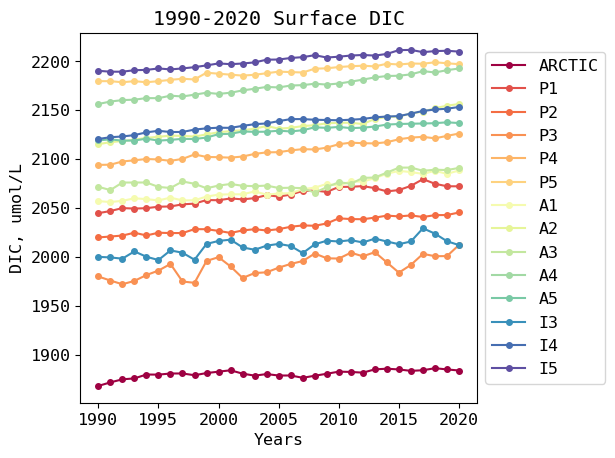

In [95]:
s = 4

fig = plt.figure()
ax = plt.subplot(111)

for j, reg in enumerate(regs):
    plt.plot(years_list, data_DICTA['TOM12_TJ_GEA0']['DIC_year_mean'][j]*1e6, marker = 'o', markersize = s,
             label = f'{reg}', color=cmap(norm(regdict[reg]['number'])))

plt.title(f'{yrst}-{yrend} Surface DIC')
plt.xlabel('Years')
plt.ylabel('DIC, umol/L')

# Legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

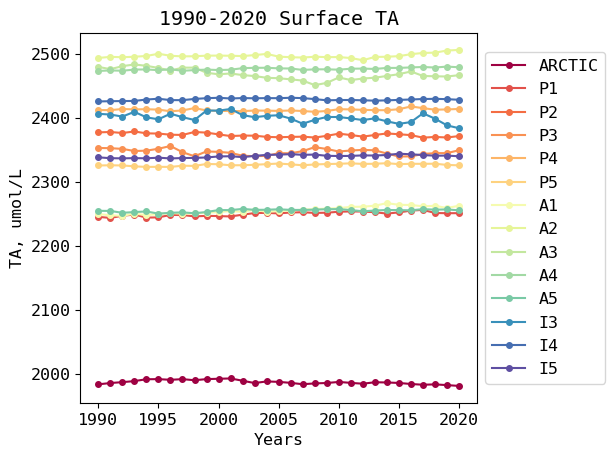

In [97]:
fig = plt.figure()
ax = plt.subplot(111)

for j, reg in enumerate(regs):
    plt.plot(years_list, data_DICTA['TOM12_TJ_GEA0']['TA_year_mean'][j]*1e6, marker = 'o', markersize = s,
             label = f'{reg}', color=cmap(norm(regdict[reg]['number'])))

plt.title(f'{yrst}-{yrend} Surface TA')
plt.xlabel('Years')
plt.ylabel('TA, umol/L')

# Legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()